# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


### Визуальный анализ ряда

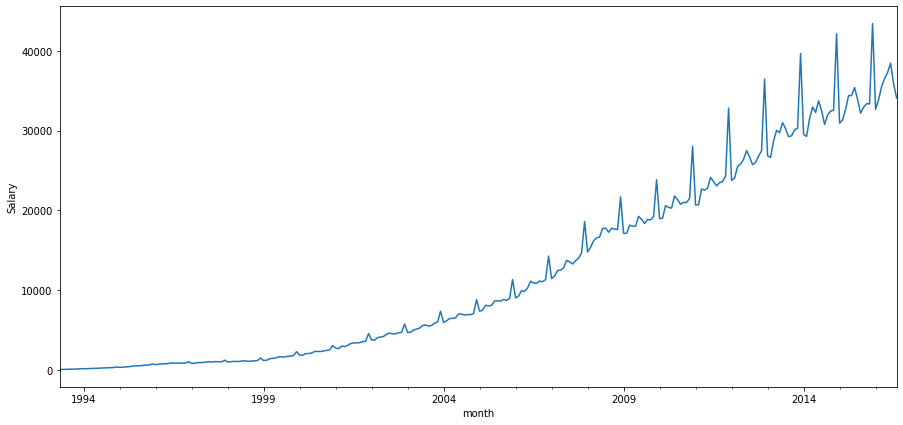

In [9]:
salary = pd.read_excel('WAG_C_M.xlsx', index_col=0, parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Визуально можно предположить, что ряд нестационарный - у него наблюдается тренд, проверим это с помощью критерия Дики-Фуллера

Критерий Дики-Фуллера: p=0.991667


<Figure size 1080x720 with 0 Axes>

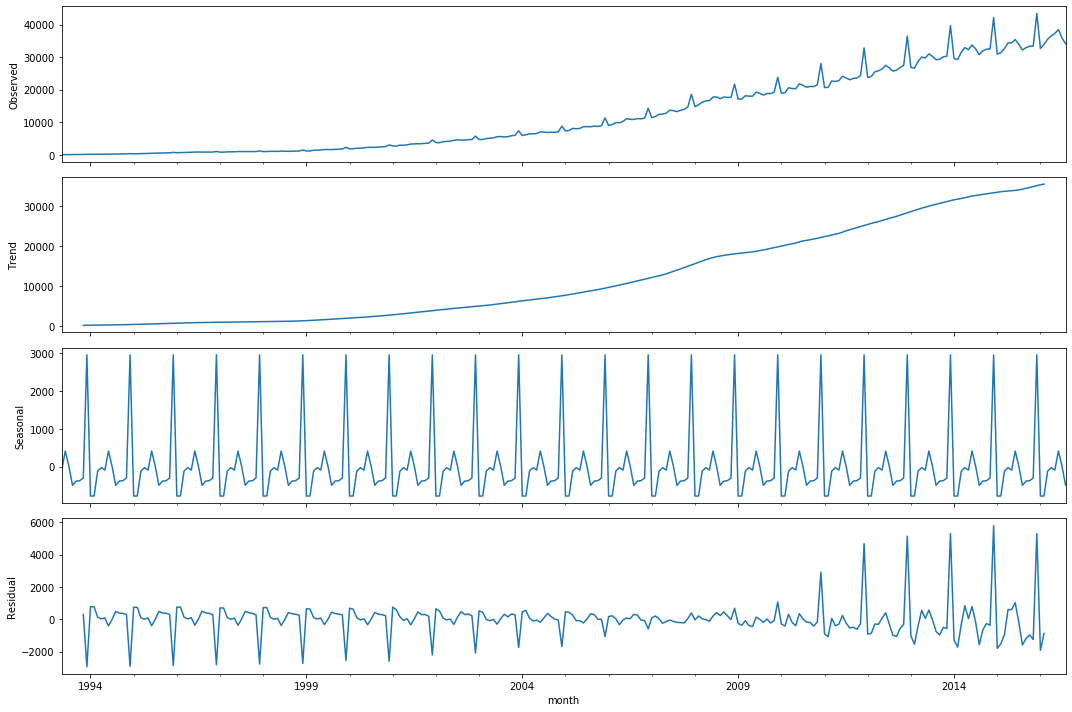

In [10]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,99. То есть нулевая гипотеза нестационарности не отвергается, и этот ряд критерий Дики-Фуллера считает нестационарным. 

Рассмотрим результат STL-декомпозиции. Видим повышающийся тренд, хорошо выраженный сезонный профиль

### Стабилизация дисперсии
У этого ряда, кажется, нестационарная дисперсия. Размах сезонных колебаний здесь в начале ряда меньше, чем в конце. Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.257063
Критерий Дики-Фуллера: p=0.688484


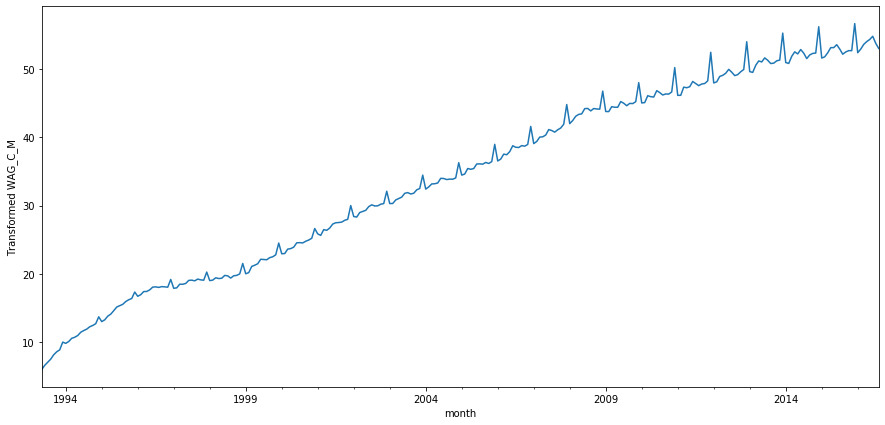

In [11]:
salary['WAG_C_M_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed WAG_C_M')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box)[1])

### Стационарность
Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Проведём сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.033416


<Figure size 1080x720 with 0 Axes>

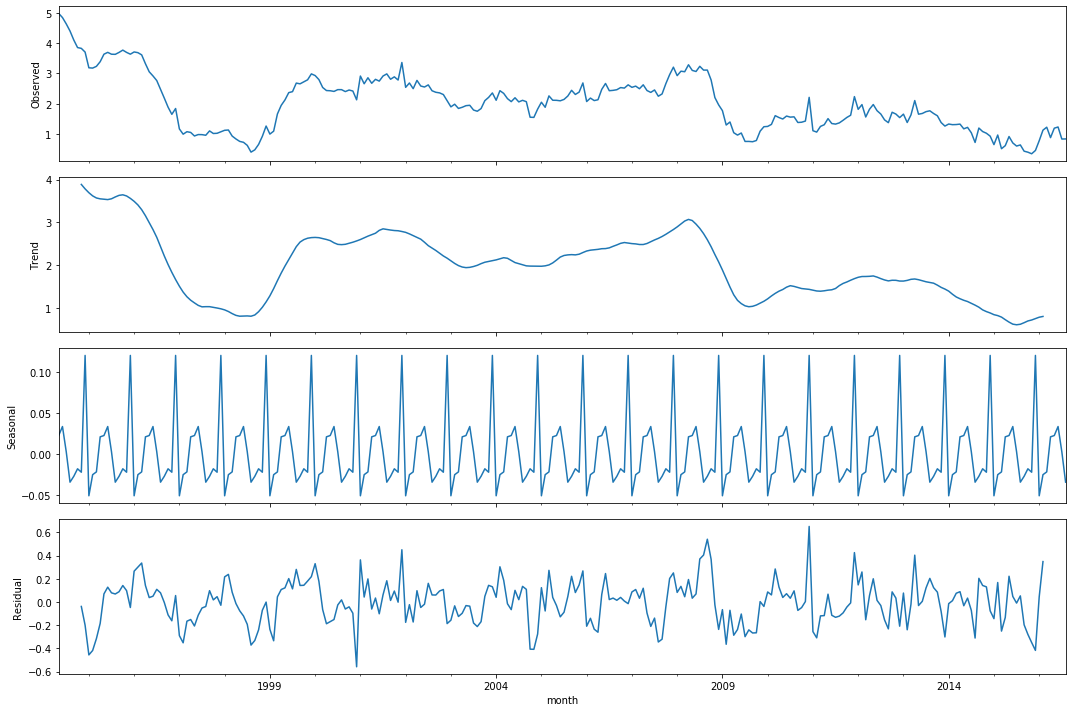

In [12]:
salary['WAG_C_M_box_diff'] = salary.WAG_C_M_box - salary.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff[12:])[1])

Полностью избавиться от тренда не удалось. Проведём ещё и обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000001


<Figure size 1080x720 with 0 Axes>

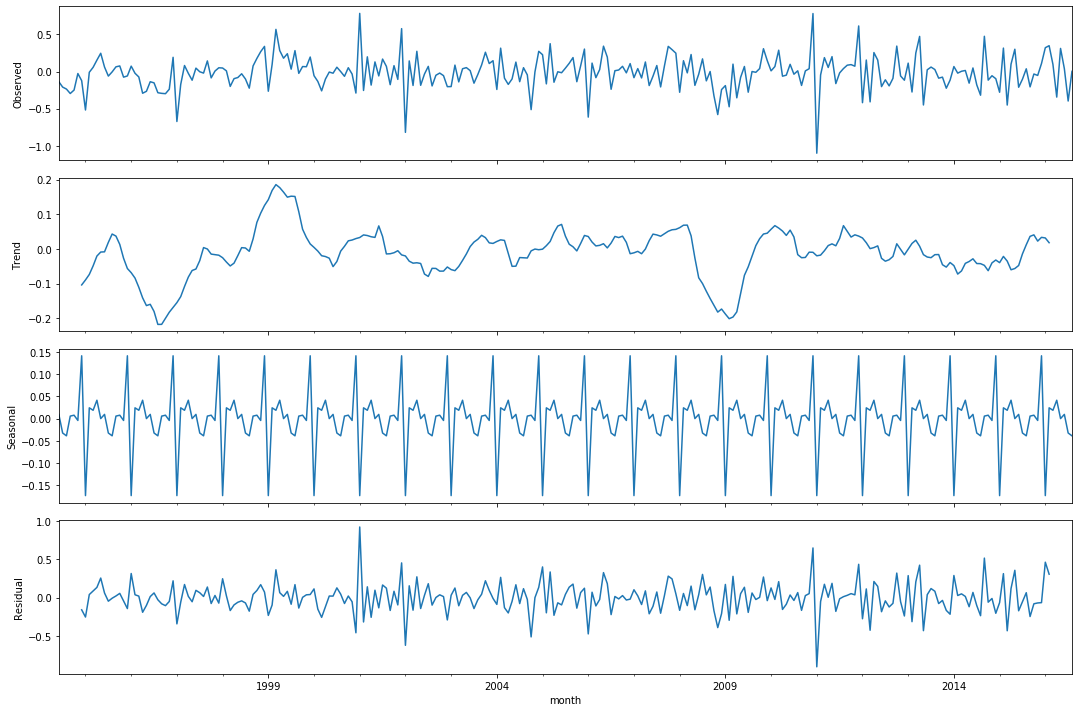

In [13]:
salary['WAG_C_M_box_diff2'] = salary.WAG_C_M_box_diff - salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит стационарным. 

## Подбор модели
Рассмотрим ACF и PACF полученного ряда:

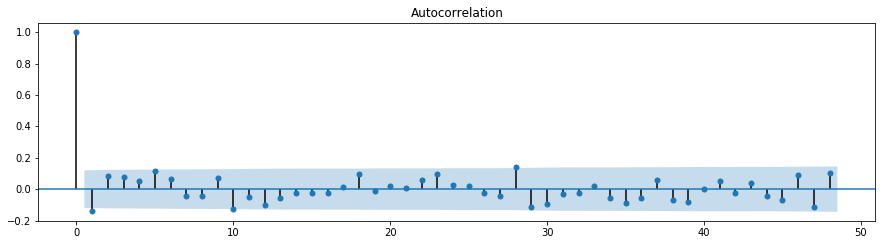

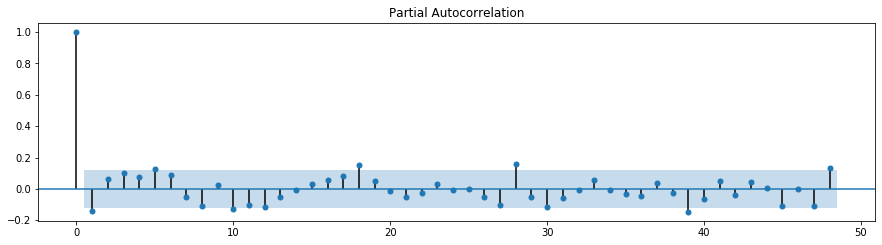

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=1, P=4, p=10

In [18]:
ps = range(0, 11)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [19]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

110

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 15min 1s


C:\Users\Admin\Anaconda3\lib\site-packages\IPython\utils\timing.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  return time.clock(),0.0


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters        aic
61    (6, 0, 1, 0) -35.949028
106  (10, 1, 1, 0) -35.230086
62    (6, 0, 2, 0) -34.658629
105  (10, 1, 0, 0) -34.295194
64    (6, 0, 4, 0) -34.203926


Лучшая модель:

In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(6, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  25.975
Date:                            Sat, 05 Sep 2020   AIC                            -35.949
Time:                                    00:07:20   BIC                             -7.251
Sample:                                05-01-1993   HQIC                           -24.421
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1954      0.046     -4.243      0.000      -0.286      -0.105
ar.L2          0.0220      0.067   

Её остатки:

Критерий Стьюдента: p=0.347993
Критерий Дики-Фуллера: p=0.000000


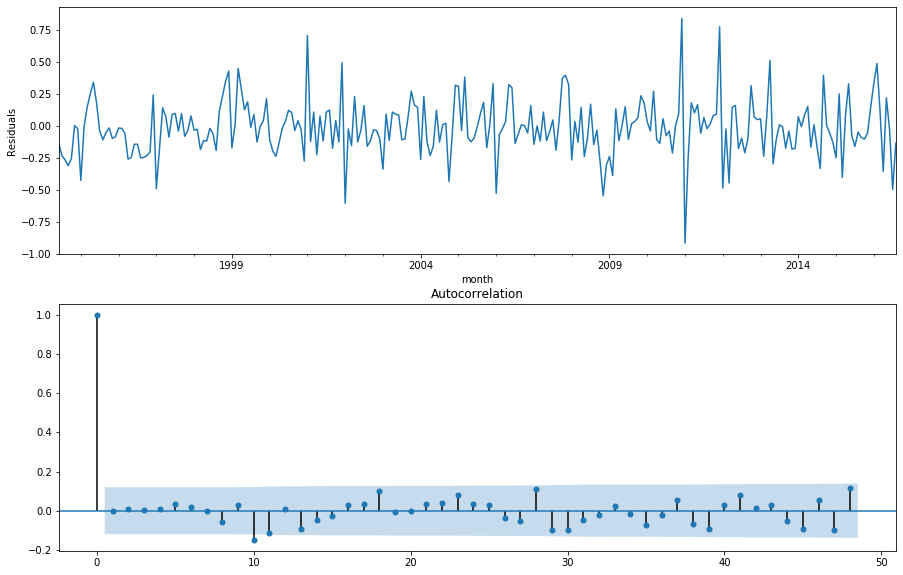

In [26]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы. Посмотрим, насколько хорошо модель описывает данные:

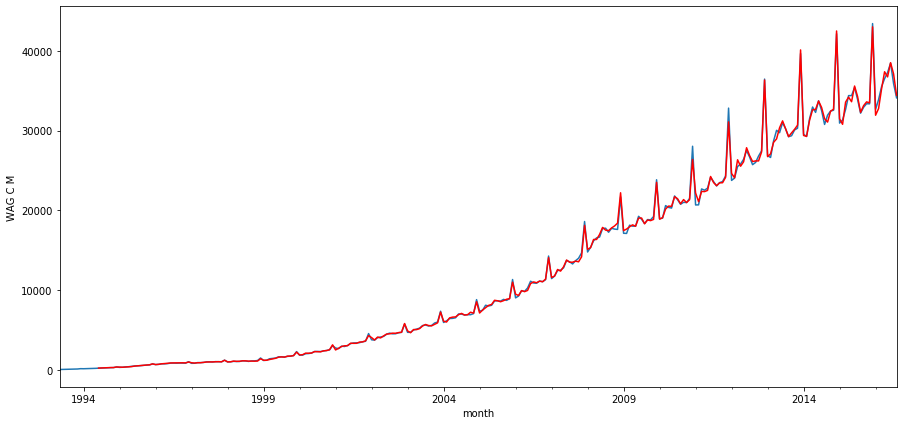

In [27]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('WAG C M')
pylab.show()

Видим, что действительно модель и данные достаточно похожи друг на друга.

### Прогноз

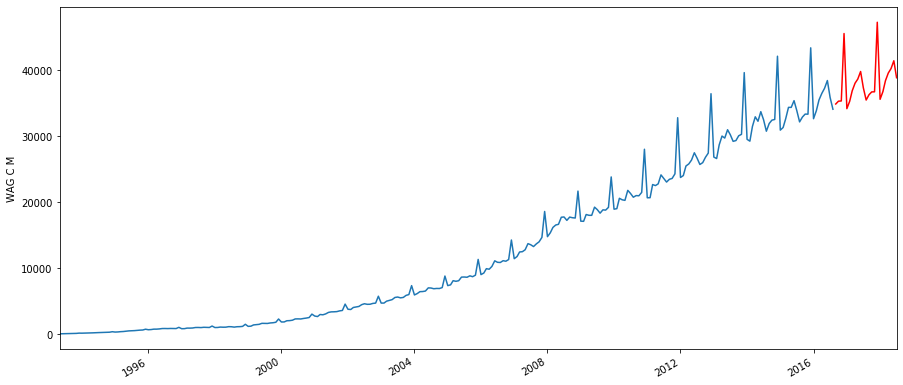

In [30]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=280, end=303), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('WAG C M')
pylab.show()

Прогноз выглядит достаточно адекватным. Он передаёт то, что мы знаем о сезонности, глядя на предыдущий кусок ряда, и в нём сохраняется возрастающий тренд. 